In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class APHomoTetramer(specifications.CoiledCoil):
    """Specification for creating antiparallel, homotetrameric coiled coils."""
    
    oligomeric_state = 4
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 4 helices, we have 4 values for each of these, but in this case they
        # are the same as we're making a homotetramer
        self.aas = [helix_length, helix_length, helix_length, helix_length]
        self.major_radii = [radius, radius, radius, radius]
        self.major_pitches = [pitch, pitch, pitch, pitch]
        self.z_shifts = [zshift, 0, zshift, 0] # inverted topology
        self.phi_c_alphas = [phica, phica, phica, phica]
        
        # We need to set the orientation of the helices
        self.orientations = [1, -1, 1, -1] # antiparallel specification

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GELKAIAQELKAIAKELKAIAWEEKAIAQG', 'GELKAIAQELKAIAKELKAIAWEEKAIAQG', 'GELKAIAQELKAIAKELKAIAWEEKAIAQG', 
             'GELKAIAQELKAIAKELKAIAWEEKAIAQG']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 30),
    optimisation.Parameter.dynamic('Radius', 6.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 350, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['f'], 27),
    optimisation.Parameter.static('ZShift', 15), # z-shift fixed at 15 A
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[30, 6.0, 350, 154.2, 15]


### Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(APHomoTetramer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	86   	-1645.69	178.521	-1896.02	-1249.21
1  	66   	-1804.98	62.24  	-1920.89	-1660.04
2  	80   	-1860.48	31.1808	-1920.89	-1791.35
3  	73   	-1885.75	17.7169	-1920.89	-1848.99
4  	70   	-1898.87	10.6001	-1920.89	-1884.85
5  	72   	-1909.37	10.3006	-1920.89	-1893.42
6  	68   	-1917.5 	3.36569	-1921.19	-1904.74
7  	68   	-1919.77	1.10143	-1922.31	-1916.65
8  	68   	-1920.67	0.472811	-1922.49	-1919.94
9  	64   	-1921.1 	0.571216	-1923.27	-1920.44
10 	67   	-1921.48	0.641469	-1923.27	-1920.7 
11 	67   	-1921.85	0.661025	-1923.27	-1920.86
12 	69   	-1922.45	0.470458	-1923.38	-1921.53
13 	65   	-1922.78	0.340972	-1923.58	-1922.12
14 	69   	-1923.08	0.23552 	-1923.58	-1922.68
15 	63   	-1923.25	0.224371	-1923.67	-1922.87
16 	72   	-1923.42	0.150594	-1923.71	-1923.12
17 	77   	-1923.54	0.105478	-1923.78	-1923.33
18 	79   	-1923.6 	0.0744675	-1923.87	-1923.47
19 	74   	-1923.64	0.0768757	-1923.87	-1923.53
20 	61   	-1923.66	0.0740884	-1923.88	-19

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-1923.9157728012617

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

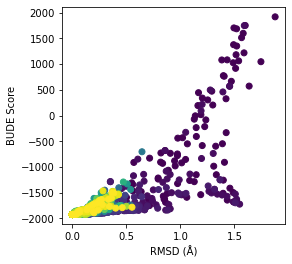

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('ga.png')

In [16]:
f = open('CC-Hex-L24E-tet-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [17]:
opt_de = ev_opts.DE(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-1181.15	651.873	-1862.25	1474.71
1  	100  	-1499.36	323.611	-1862.25	-10.3279
2  	100  	-1623.98	211.384	-1862.25	-925.316
3  	100  	-1710.04	137.243	-1900.24	-1255.82
4  	100  	-1769.82	87.4149	-1900.24	-1446.31
5  	100  	-1815.21	52.9367	-1911.44	-1638.9 
6  	100  	-1842.53	36.8029	-1914.84	-1731.41
7  	100  	-1856.03	31.4798	-1917.15	-1786.17
8  	100  	-1870.11	26.8386	-1917.15	-1786.17
9  	100  	-1882.65	22.8251	-1919.82	-1829.85
10 	100  	-1892.92	17.623 	-1920.45	-1852.99
11 	100  	-1900.4 	14.3402	-1923.83	-1856.41
12 	100  	-1906.55	11.8216	-1923.83	-1877.04
13 	100  	-1911.45	9.94637	-1923.83	-1880.97
14 	100  	-1916.49	4.91518	-1923.83	-1895.94
15 	100  	-1918.55	3.21905	-1924.22	-1909.66
16 	100  	-1919.82	2.63886	-1924.42	-1909.66
17 	100  	-1921.11	1.83751	-1924.42	-1916.05
18 	100  	-1921.93	1.41745	-1924.64	-1918.47
19 	100  	-1922.49	1.24182	-1924.64	-1918.47
20 	100  	-1923.12	0.952767	-1924.64	-1920.59
21 	100  	-

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-1924.8495114397485

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

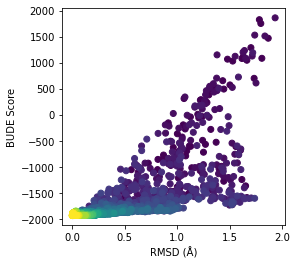

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('de.png')

In [23]:
f = open('CC-Hex-L24E-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-1310.73	497.673	-1891.42	1029.26
1  	81   	-1556.68	428.025	-1923.99	1029.26
2  	66   	-1281.08	430.558	-1825.7 	59.7934
3  	94   	-966.649	573.252	-1749.72	643.683
4  	95   	-1462.04	382.061	-1852.49	391.261
5  	81   	-1614.3 	215.91 	-1921.45	-828.921
6  	73   	-1298.1 	435.405	-1917.64	148.264 
7  	74   	-1215.99	568.708	-1812.67	831.964 
8  	66   	-1368.52	475.97 	-1875.64	779.959 
9  	67   	-1537.94	349.782	-1887.4 	98.3341 
10 	61   	-1363.94	360.219	-1872.62	-236.924
11 	87   	-843.386	592.608	-1824.38	766.007 
12 	42   	-970.722	600.69 	-1883.3 	766.007 
13 	61   	-1351.74	462.173	-1835.03	178.943 
14 	59   	-1162.33	482.457	-1793.16	269.181 
15 	80   	-1302.65	548.153	-1841.44	1698.74 
16 	87   	-1183.4 	565.969	-1860.92	1698.74 
17 	88   	-1482.9 	362.797	-1919.51	-51.3407
18 	70   	-1561.76	309.628	-1887.4 	-162.729
19 	54   	-1515.18	319.974	-1849.43	-162.729
20 	71   	-1378.96	333.265	-1894.3 	-513.436
21 	91   	-1346.

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-1923.9873321325945

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

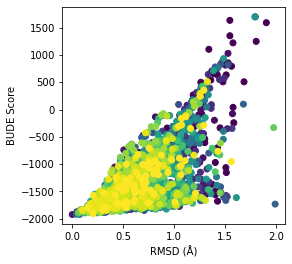

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('pso.png')

In [30]:
f = open('CC-Hex-L24E-tet-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(APHomoTetramer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max    
0  	100  	-945.345	446.148	-1788.83	319.425
1  	100  	-1214.98	713.223	-1879.46	924.984
2  	100  	-1350.2 	623.013	-1820.39	1313.97
3  	100  	-1765.58	66.3583	-1892.54	-1390.11
4  	100  	-1758.18	91.9197	-1897.61	-1371.99
5  	100  	-1783.33	110.384	-1919.14	-1314.49
6  	100  	-1862.34	33.483 	-1922.15	-1771.71
7  	100  	-1887.37	27.5852	-1922.79	-1802.79
8  	100  	-1901.89	22.4159	-1922.27	-1824.83
9  	100  	-1909.92	19.3995	-1924.1 	-1804.33
10 	100  	-1907.56	19.636 	-1923.5 	-1858.8 
11 	100  	-1919.45	10.6282	-1924.67	-1865.78
12 	100  	-1910.47	23.599 	-1924.54	-1828.24
13 	100  	-1915.44	17.4791	-1924.71	-1853.58
14 	100  	-1914.82	20.63  	-1924.78	-1838.52
15 	100  	-1910.29	28.1186	-1924.78	-1831.58
16 	100  	-1915.1 	20.4536	-1924.88	-1846.41
17 	100  	-1923.65	6.12812	-1924.96	-1881.35
18 	100  	-1924.6 	0.557645	-1924.91	-1919.15
19 	100  	-1924.57	1.04728 	-1924.96	-1914.19
20 	100  	-1924.68	0.092852	-1924.87	-1924.3 
21 	100  	-

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-1924.9640480730523

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

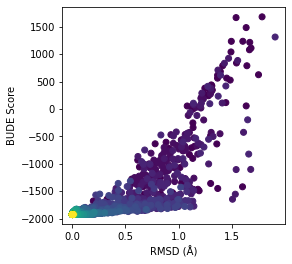

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUDE Score')

fig.savefig('cmaes.png')

In [37]:
f = open('CC-Hex-L24E-tet-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)